> # TELECOM CHURN CASE STUDY                      
> ### GP SHIVA PRASAD, CHENNIBABU DOGIPARTHI
> # Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
- For many incumbent operators, retaining high profitable customers is the number one business goal.
- To reduce customer churn, telecom companies need to predict which customers are at high risk of churn
- In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.
> ## Understanding and Defining Churn
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).
In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.
However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).
Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.
- This project is based on the Indian and Southeast Asian market.
> **Definitions of Churn**
There are various ways to define churn, such as:
> **Revenue-based churn:** Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.
- The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.
>**Usage-based churn:** Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.
- A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.
- In this project, you will use the usage-based definition to define churn.
> ### High-value Churn
In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.
- In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

>**Understanding the Business Objective and the Data**
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 
- The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

>**Understanding Customer Behaviour During Churn**
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :
   - The `good` phase: In this phase, the customer is happy with the service and behaves as usual.
   - The `action` phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)
   - The `churn` phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.
- In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

> # 0. Importing modules 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',250)

> <b>Function to reduce memory usage of the data set</b>
- Converting dtypes of numerical columns having dtype as 'int' to 'int8' or 'int16' or 'int32' or 'int64' depending on the max and min values of respective columns
- Converting dtypes of numerical columns having dtype as 'float' to 'float32' or 'float64'
- `Doing this to reduce the resources and time taken by the models`

In [2]:
def reduce_mem_usg(df):
    start_mem = df.memory_usage().sum()/1024**2 # gives the memory usage of uncompressed df
    for col in df.columns:
        dtype = df[col].dtype
        if dtype != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(dtype)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max<np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max<np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max<np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max<np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max<np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.iinfo(np.float64).min and c_max<np.iinfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum()/1024**2
    print('original df memory usage',round(start_mem,2),'MB -->',round(end_mem,2),'MB, reduced by',round(((start_mem-end_mem)/start_mem)*100,2),'%')
    return df

# 1. Importing CSV and Data Inspection

In [3]:
churn_df = pd.read_csv('telecom_churn_data.csv')
reduce_mem_usg(churn_df)
churn_df.head()

original df memory usage 172.42 MB --> 83.83 MB, reduced by 51.38 %


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.384995,214.815994,213.802994,21.100000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.160000,NaN,NaN,NaN,4.130000,NaN,NaN,NaN,1.150000,NaN,NaN,NaN,5.440000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.00,NaN,NaN,N

In [4]:
churn_df.shape

(99999, 226)

- There are `99999 rows` and `226 columns` in the data set

In [5]:
churn_df.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

In [6]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float32(179), int16(13), int32(4), int64(1), int8(17), object(12)
memory usage: 83.8+ MB


In [7]:
churn_df.dtypes.sort_values()

sachet_2g_7                    int8
monthly_2g_6                   int8
monthly_2g_7                   int8
monthly_2g_8                   int8
monthly_2g_9                   int8
sachet_2g_6                    int8
sachet_2g_8                    int8
monthly_3g_6                   int8
monthly_3g_7                   int8
monthly_3g_8                   int8
monthly_3g_9                   int8
sachet_3g_6                    int8
sachet_2g_9                    int8
sachet_3g_8                    int8
sachet_3g_7                    int8
circle_id                      int8
sachet_3g_9                    int8
max_rech_amt_9                int16
total_rech_num_7              int16
total_rech_num_8              int16
total_rech_num_9              int16
max_rech_amt_6                int16
max_rech_amt_8                int16
max_rech_amt_7                int16
last_day_rch_amt_8            int16
aon                           int16
last_day_rch_amt_7            int16
last_day_rch_amt_6          

> <b>`Checking Null values`

In [8]:
null_df = pd.DataFrame(churn_df.isnull().sum().sort_values(ascending=False))
null_df['% of null values'] = 100*(null_df[0]/churn_df.shape[0])
null_df.rename({0:'No of Null Values'}, axis = 1)

,No of Null Values,% of null values
count_rech_2g_6,74846,74.846748
date_of_last_rech_data_6,74846,74.846748
count_rech_3g_6,74846,74.846748
av_rech_amt_data_6,74846,74.846748
max_rech_data_6,74846,74.846748
total_rech_data_6,74846,74.846748
arpu_3g_6,74846,74.846748
arpu_2g_6,74846,74.846748
night_pck_user_6,74846,74.846748
fb_user_6,74846,74.846748


> <b>`Checking for duplicate entries`

In [9]:
churn_df.drop_duplicates(keep='first', inplace=True)
churn_df.shape

(99999, 226)

> <b>`INSIGHT`</b>
- The data set has 99999 rows and 226 columns
- Some columns are having null percentage, highest being `74.85%`
- There are no duplicate entries in the data set
- <b> Some columns` dtypes should be changed to appropriate dtypes</b>

# 2. Feature Engineering 

> In churn prediction, we assume that there are three phases of customer lifecycle :

|Phase|Month|
|--|--|
|The <b>`good`</b> phase|Month 6 & 7
|The <b>`action`</b> phase |Month 8
|The <b>`churn`</b> phase |Month 9    
     
> In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.
> ## 2.1 Filtering out `High-Value Customers`
 As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

> ### Process followed to filter out the `High Value Customers`    
 1. First we get the product of `av_rech_amt_data_6/7` and `churn_df.total_rech_data_6/7` and name it **`total_data_recharge_6/7`** respectively.
 2. Then, we add `total_data_recharge_6`, `total_rech_amt_6` and name it `Total_recharge_6`, `total_data_recharge_7`, `total_rech_amt_7` and name it <b>`Total_recharge_7`</b>
 3. We get the average of `Total_recharge_6` and `Total_recharge_7` and name it **`Average_recharge_6_7`**
 4. We filter out the dataset based on the `70 percetile` of the `Average_recharge_6_7` 

In [10]:
churn_df[['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']].describe()

,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
count,25153.000000,25571.000000,26339.000000,99999.000000,99999.000000,99999.000000
mean,192.600967,200.981308,197.526505,327.514615,322.962970,324.157122
std,192.641098,196.788025,191.302185,398.019701,408.114237,416.540455
min,1.000000,0.500000,0.500000,0.000000,0.000000,0.000000
25%,82.000000,92.000000,87.000000,109.000000,100.000000,90.000000
50%,154.000000,154.000000,154.000000,230.000000,220.000000,225.000000
75%,252.000000,252.000000,252.000000,437.500000,428.000000,434.500000
max,7546.000000,4365.000000,4076.000000,35190.000000,40335.000000,45320.000000


> **We are filling `Null` values of these six columns with `0.0`. Considering there were no recharges done by the customer.** 

In [11]:
for i in range(6,9):
    churn_df['total_rech_data_'+str(i)] = churn_df['total_rech_data_'+str(i)].replace(np.NaN,0.0)
    
    churn_df['av_rech_amt_data_'+str(i)] = churn_df['av_rech_amt_data_'+str(i)].replace(np.NaN,0.0)
    
    churn_df['total_data_recharge_'+str(i)] = churn_df['av_rech_amt_data_'+str(i)] * churn_df['total_rech_data_'+str(i)]

churn_df['Average_recharge_6_7'] = (churn_df.total_rech_amt_6 + churn_df.total_data_recharge_6 + churn_df.total_rech_amt_7+ churn_df.total_data_recharge_7)/2

Avg_recharge_6_7_70percentile = churn_df.Average_recharge_6_7.quantile(0.7)
print(Avg_recharge_6_7_70percentile)

478.0


In [12]:
churn_df = churn_df[churn_df.Average_recharge_6_7 >= Avg_recharge_6_7_70percentile]
churn_df.shape

(30001, 230)

> ## 2.2 Tag churners and remove attributes of the churn phase
Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:
    * total_ic_mou_9
    * total_og_mou_9
    * vol_2g_mb_9
    * vol_3g_mb_9
After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [13]:
churn_df[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].isnull().sum()

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [14]:
# Creating a column `churn` and filling it up with 0 as default value
churn_df['churn'] = 0

# condition
churn_status = (churn_df.total_ic_mou_9 == 0.0) & (churn_df.total_og_mou_9 == 0.0) & (churn_df.vol_2g_mb_9 == 0.0) & (churn_df.vol_3g_mb_9 == 0.0)

# replacing 0 with 1 when the condition `churn_status` is True
churn_df.loc[churn_status,'churn'] = 1

100*(churn_df.churn.sum()/churn_df.shape[0])

8.136395453484884

> After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [15]:
churn_df.drop(churn_df.columns[churn_df.columns.str.contains('_9')], axis = 1, inplace = True)
churn_df.shape

(30001, 177)

# 3 EDA
> ###  3.1 Data Preprocessing (Convert columns to appropriate dtypes, handle missing values)
   **Dropping the columns having only one unique value**

In [16]:
churn_df.drop(churn_df.columns[churn_df.nunique() == 1], axis = 1, inplace = True)
churn_df.shape

(30001, 164)

> **Converting columns having dates into `datetime64[ns]`**

In [17]:
date_col = churn_df.columns[churn_df.columns.str.contains('date')]

for col in date_col:
    churn_df[col] = pd.to_datetime(churn_df[col])
churn_df[date_col].dtypes

date_of_last_rech_6         datetime64[ns]
date_of_last_rech_7         datetime64[ns]
date_of_last_rech_8         datetime64[ns]
date_of_last_rech_data_6    datetime64[ns]
date_of_last_rech_data_7    datetime64[ns]
date_of_last_rech_data_8    datetime64[ns]
dtype: object

> ### `Recharge` related variables

In [18]:
rech_col = list(churn_df.columns[churn_df.columns.str.contains('rech_amt' or 'recharge')]) + list(churn_df.columns[churn_df.columns.str.contains('recharge')])
rech_col

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_data_recharge_6',
 'total_data_recharge_7',
 'total_data_recharge_8',
 'Average_recharge_6_7']

> **`total_rech_amt` & `total_data_recharge`** 

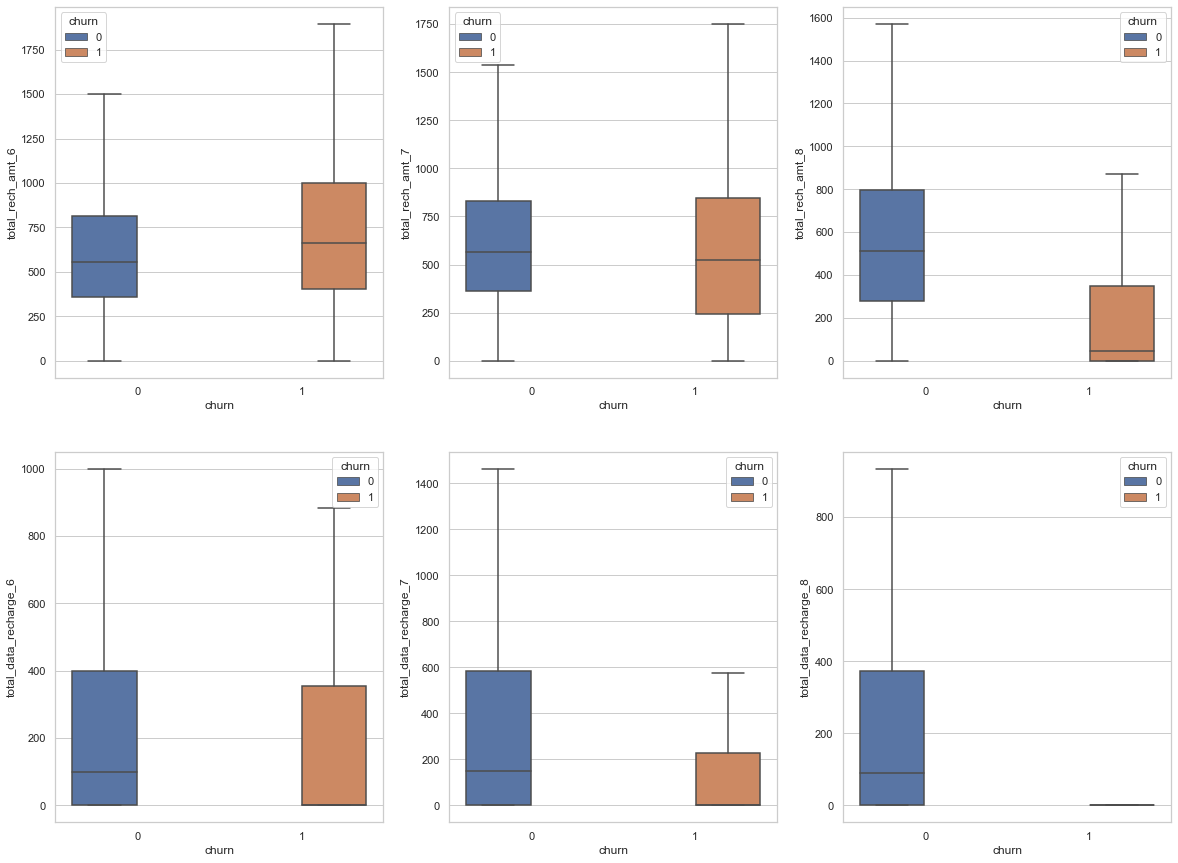

In [19]:
mnth = 6
plt.figure(figsize = (20,15))
for i in range(1,7):
    plt.subplot(2,3,i)
    if i<=3:
        sns.boxplot(x = churn_df.churn, y = churn_df['total_rech_amt_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1
    else:
        if mnth == 9:
            mnth = 6
        sns.boxplot(x = churn_df.churn, y = churn_df['total_data_recharge_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1    

> **INSIGHT**   
> `total_rech_amt`:  We can see a `drop` in the total recharge amount for churned customers in the `8th Month (Action Phase)`.
> `total_data_recharge`: We can see that there is a `huge drop` in total recharge amount for data in the `8th month (Action phase)` for churned customers.

> **`max_rech_amt`** & **`av_rech_amt_data`**

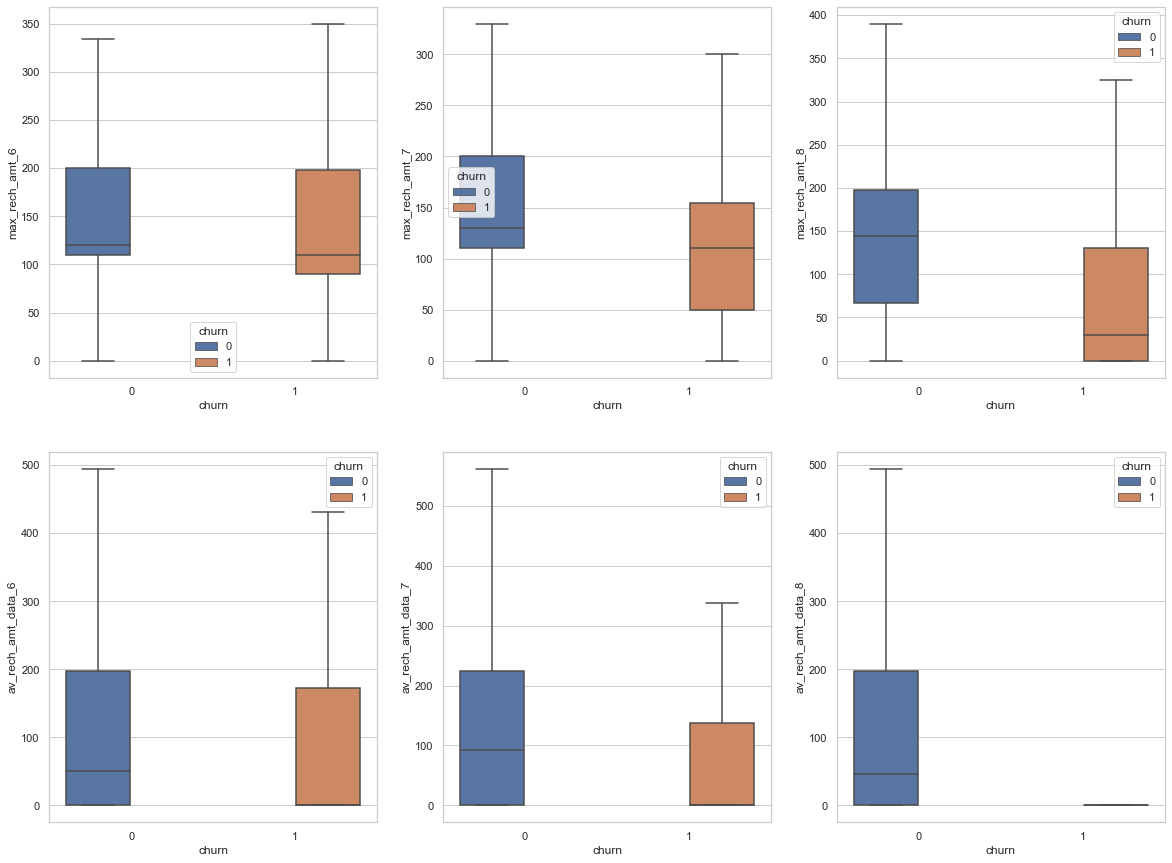

In [20]:
mnth = 6
plt.figure(figsize = (20,15))
for i in range(1,7):
    plt.subplot(2,3,i)
    if i<=3:
        sns.boxplot(x = churn_df.churn, y = churn_df['max_rech_amt_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1
    else:
        if mnth == 9:
            mnth = 6
        sns.boxplot(x = churn_df.churn, y = churn_df['av_rech_amt_data_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1    

> **INSIGHT**   
- `max_rech_amt`:  We can see a `drop` in the total recharge amount for churned customers in the `8th Month (Action Phase)`.
- `av_rech_amt_data`: We can see that there is a `huge drop` in total recharge amount for data in the `8th month (Action phase)` for churned customers.

In [21]:
100*(churn_df[churn_df.columns[churn_df.columns.str.contains('rech_num|max_rech_data', regex = True)]].isnull().sum()/churn_df.shape[0]).sort_values(ascending=False)

max_rech_data_8     46.825106
max_rech_data_6     44.148528
max_rech_data_7     43.145228
total_rech_num_8     0.000000
total_rech_num_7     0.000000
total_rech_num_6     0.000000
dtype: float64

In [22]:
churn_df[['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,16756.000000,17057.000000,15953.000000
mean,139.798584,140.431137,136.329224
std,118.855995,120.252129,119.535194
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


<b> `INSIGHT` </b>
- All three columns are having minimum value as 1 and maximum value as 1555, which means the missing values are where there are no recharges. Thus, imputing the `null` values with `0`

In [23]:
churn_df[['max_rech_data_6','max_rech_data_7','max_rech_data_8']] = churn_df[['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan, 0.0)
churn_df[['max_rech_data_6','max_rech_data_7','max_rech_data_8']].isnull().sum().sort_values(ascending=False)

max_rech_data_8    0
max_rech_data_7    0
max_rech_data_6    0
dtype: int64

> <b>`total_rech_num` & `max_rech_data`</b>

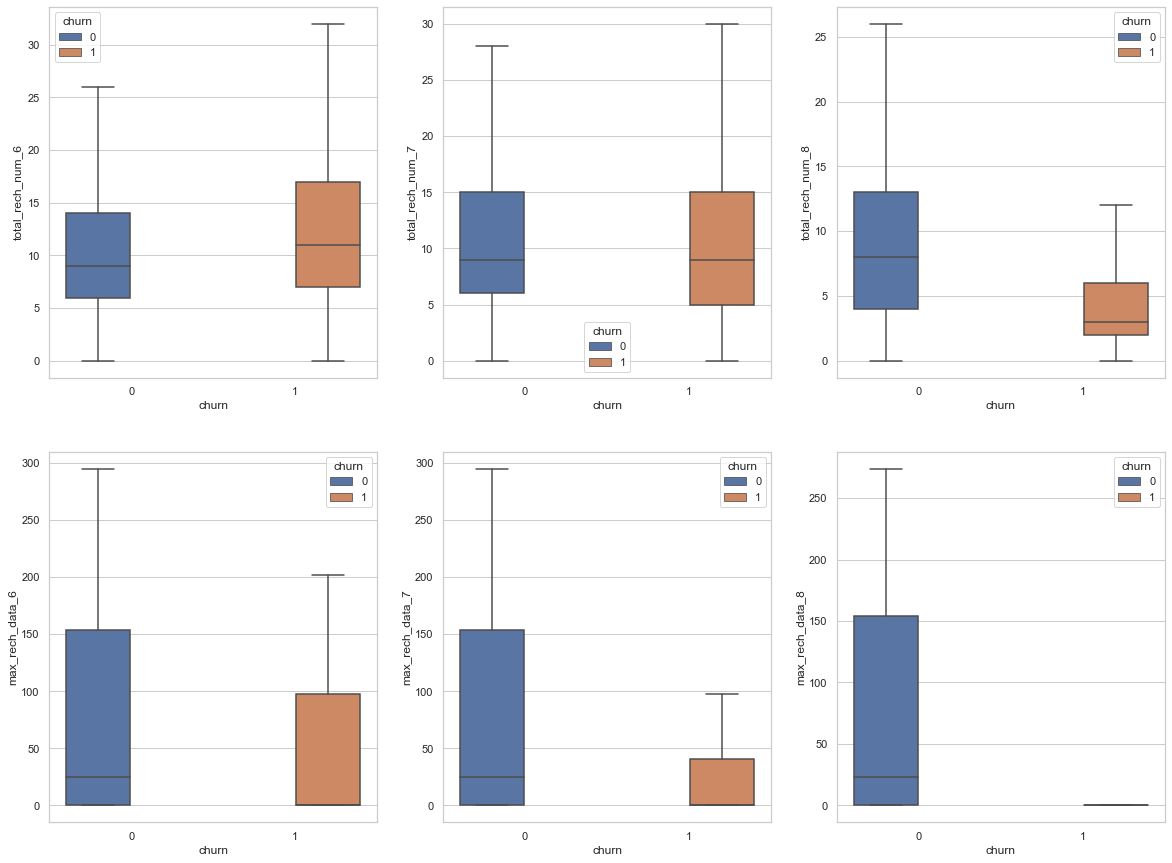

In [24]:
mnth = 6
plt.figure(figsize = (20,15))
for i in range(1,7):
    plt.subplot(2,3,i)
    if i<=3:
        sns.boxplot(x = churn_df.churn, y = churn_df['total_rech_num_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1
    else:
        if mnth == 9:
            mnth = 6
        sns.boxplot(x = churn_df.churn, y = churn_df['max_rech_data_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1    

> <b>`INSIGHT`</b> 
- There is a drop in `total recharge number` in the `8th month (action phase)` for churned customers.
- There is a huge drop in `maximum recharge for data` also in the `8th month (action phase)` for churned customers.

> <b>`last day recharge amount`

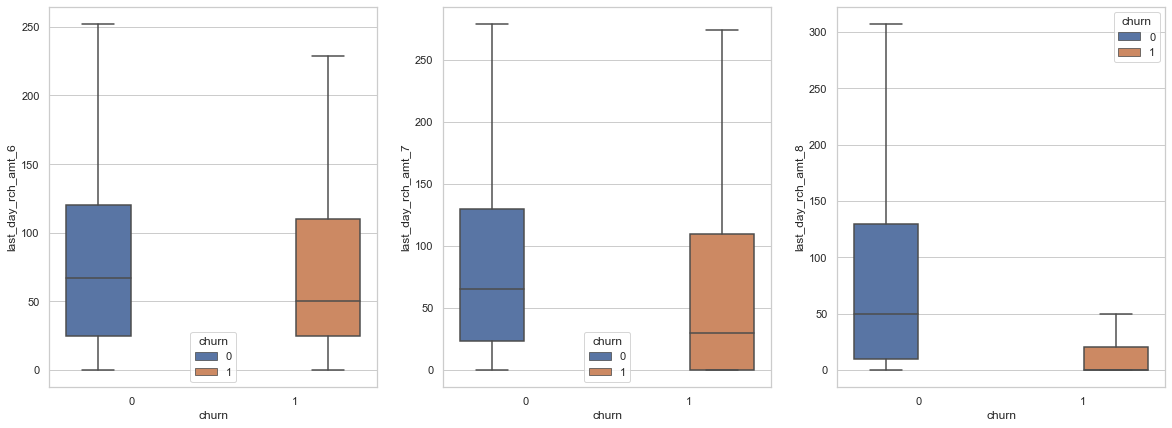

In [25]:
mnth = 6
plt.figure(figsize = (20,7))
for i in range(1,4):
    plt.subplot(1,3,i)
    if i<=3:
        sns.boxplot(x = churn_df.churn, y = churn_df['last_day_rch_amt_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1

> <b>`INSIGHT`</b>
- There is a huge drop here as well in 8th month (Active month) for churned customers

> ### Features of `2G` and `3G` usage

In [26]:
g_cols = churn_df.columns[churn_df.columns.str.contains('2g|3g',regex=True)]

100*(churn_df[g_cols].isnull().sum()/churn_df.shape[0]).sort_values(ascending=False)

arpu_2g_8          46.825106
count_rech_2g_8    46.825106
count_rech_3g_8    46.825106
arpu_3g_8          46.825106
count_rech_2g_6    44.148528
count_rech_3g_6    44.148528
arpu_3g_6          44.148528
arpu_2g_6          44.148528
count_rech_2g_7    43.145228
count_rech_3g_7    43.145228
arpu_3g_7          43.145228
arpu_2g_7          43.145228
sachet_2g_6         0.000000
monthly_2g_8        0.000000
jul_vbc_3g          0.000000
aug_vbc_3g          0.000000
sachet_3g_8         0.000000
sachet_3g_7         0.000000
sachet_3g_6         0.000000
vol_2g_mb_6         0.000000
vol_2g_mb_7         0.000000
vol_2g_mb_8         0.000000
vol_3g_mb_6         0.000000
vol_3g_mb_7         0.000000
vol_3g_mb_8         0.000000
monthly_3g_8        0.000000
monthly_3g_7        0.000000
monthly_3g_6        0.000000
sachet_2g_8         0.000000
jun_vbc_3g          0.000000
sachet_2g_7         0.000000
monthly_2g_6        0.000000
monthly_2g_7        0.000000
sep_vbc_3g          0.000000
dtype: float64

> <b>INSIGHT</b> 
- `count_rech_2g/3g` and `arpu_2g/3g` columns are missing values more than 40% and are somewhat redundant because of the `volume based 2g/3g` columns. 
- So, we can drop them without much data loss 

In [27]:
churn_df.drop(['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)
churn_df.shape

(30001, 152)

In [28]:
g_cols = churn_df.columns[churn_df.columns.str.contains('2g|3g',regex=True)]

churn_df[g_cols].describe()

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,126.522163,125.097214,105.912834,344.258484,370.195770,351.494110,0.174494,0.183261,0.153628,1.066064,1.214026,1.054865,0.217759,0.229026,0.211026,0.209393,0.227492,0.202393,169.138306,178.873001,158.523956,8.029792
std,330.557922,331.534241,313.407654,913.808472,915.570312,918.979614,0.434953,0.450423,0.406486,2.507197,2.736158,2.535940,0.613199,0.659125,0.617549,0.985674,1.089929,1.100107,420.992584,443.502869,416.710785,52.374687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,83.449997,77.769997,51.650002,358.739990,410.700012,356.190002,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,128.800003,137.289993,98.440002,0.000000
max,10285.900391,7873.549805,11117.610352,45735.398438,28144.119141,30036.060547,4.000000,5.000000,5.000000,42.000000,48.000000,44.000000,14.000000,16.000000,16.000000,29.000000,35.000000,41.000000,12916.219727,9165.599609,11166.209961,2618.570068


> **`vol_2g_mb`** & **`vol_3g_mb`**

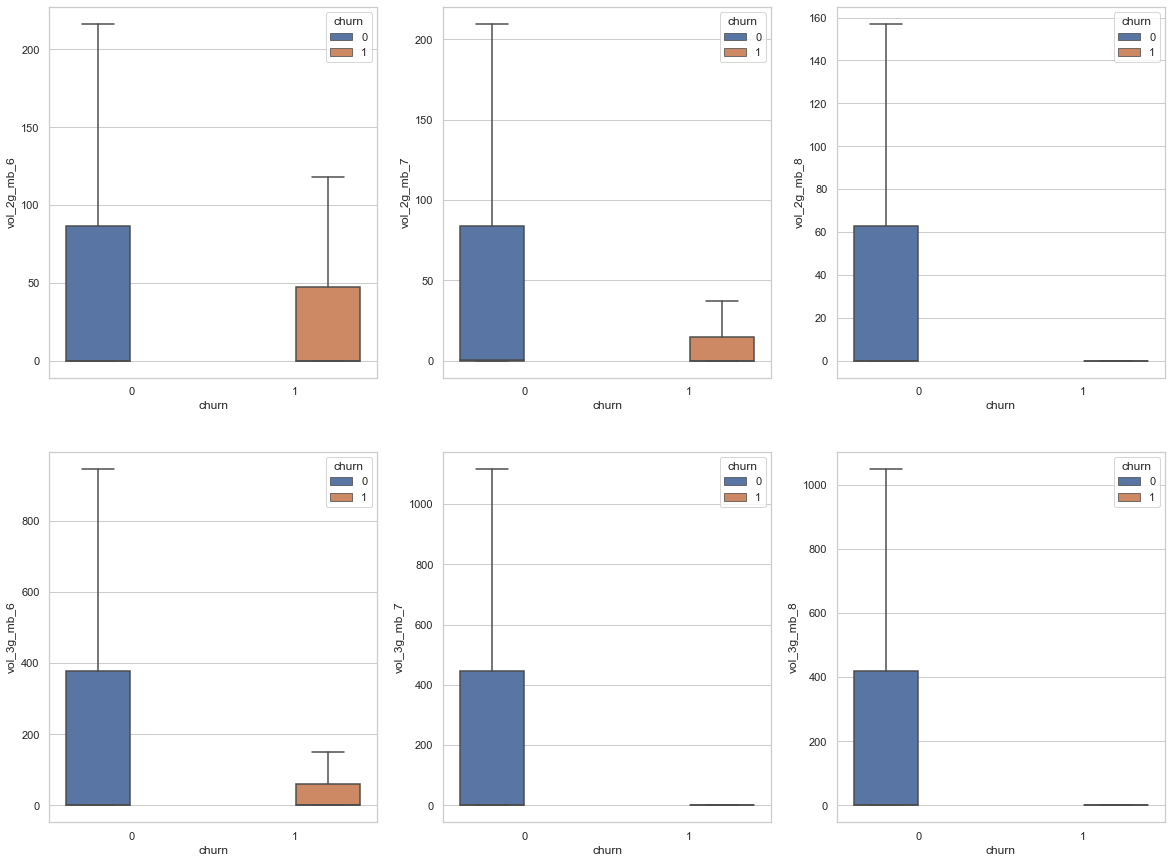

In [29]:
mnth = 6
plt.figure(figsize = (20,15))
for i in range(1,7):
    plt.subplot(2,3,i)
    if i<=3:
        sns.boxplot(x = churn_df.churn, y = churn_df['vol_2g_mb_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1
    else:
        if mnth == 9:
            mnth = 6
        sns.boxplot(x = churn_df.churn, y = churn_df['vol_3g_mb_'+str(mnth)], hue = churn_df.churn, showfliers = False)
        mnth+=1    

> <b>`INSIGHT`</b>
- `2G` and `3G` usage for churned customers dropped in 8th month (Active Months)
- `2G` and `3G` usage for non-churned customers is higher when compared to churned customers. This may indicate that Internet coverage is playing a significant role in people leaving the network

> <b>`monthly_2g` and `monthly_3g`</b>

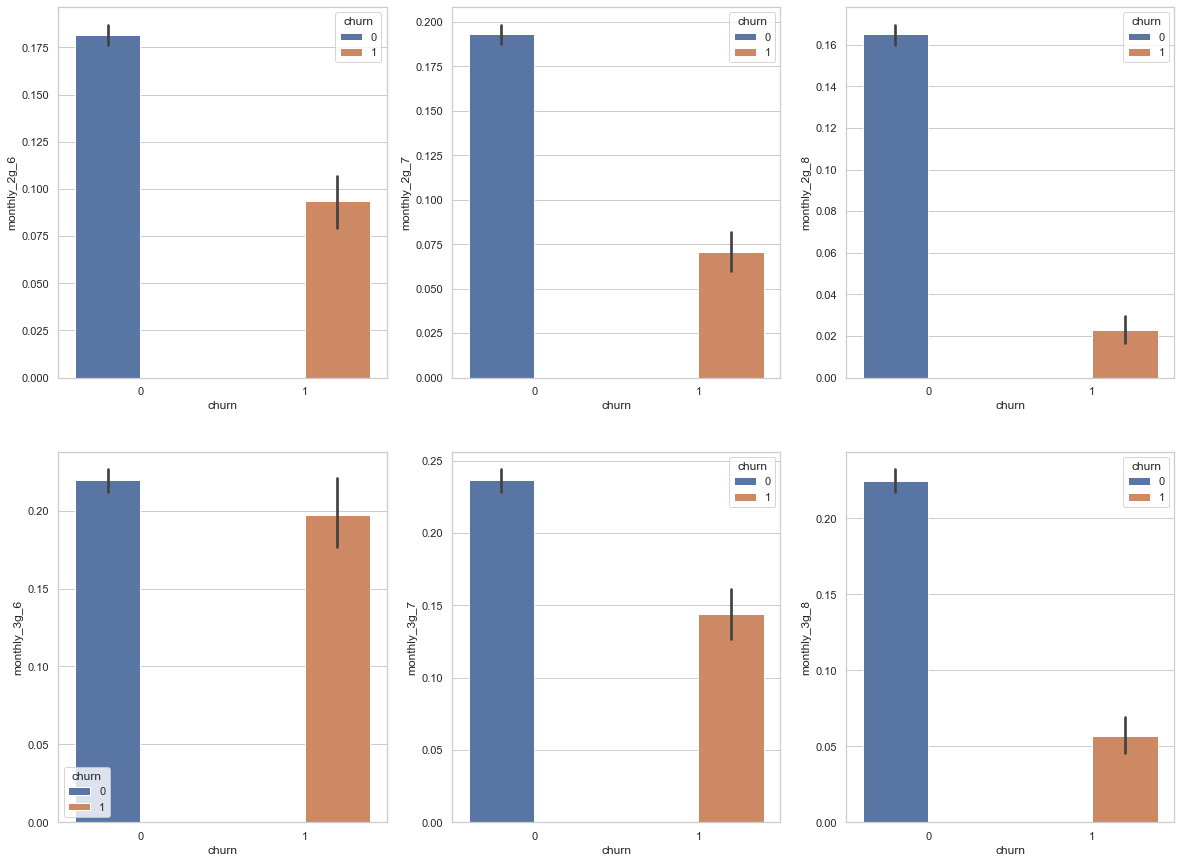

In [30]:
mnth = 6
plt.figure(figsize = (20,15))
for i in range(1,7):
    plt.subplot(2,3,i)
    if i<=3:
        sns.barplot(x = churn_df.churn, y = churn_df['monthly_2g_'+str(mnth)], hue = churn_df.churn)
        mnth+=1
    else:
        if mnth == 9:
            mnth = 6
        sns.barplot(x = churn_df.churn, y = churn_df['monthly_3g_'+str(mnth)], hue = churn_df.churn)
        mnth+=1    

> <b>INSIGHT</b>
- We can see a drop in monthly subscription for both `2G` and `3G` for churned customers in `8th month (Active Month)`

> <b>`Volume based cost (vbc)`</b>
- Dropping `sep_vbc_3g` columns because sep = 9th month
- Renaming `aug_vbc_3g` to `vbc_3g_8`, `jul_vbc_3g` to `vbc_3g_7`,`jun_vbc_3g` to `vbc_3g_6` for the sake of consistency

In [31]:
churn_df.drop('sep_vbc_3g', axis = 1, inplace = True)

churn_df.rename({'aug_vbc_3g': 'vbc_3g_8', 'jul_vbc_3g': 'vbc_3g_7', 'jun_vbc_3g':'vbc_3g_6' }, axis = 1, inplace = True)
vbc_col = churn_df.columns[churn_df.columns.str.contains('vbc')]
vbc_col

Index(['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6'], dtype='object')

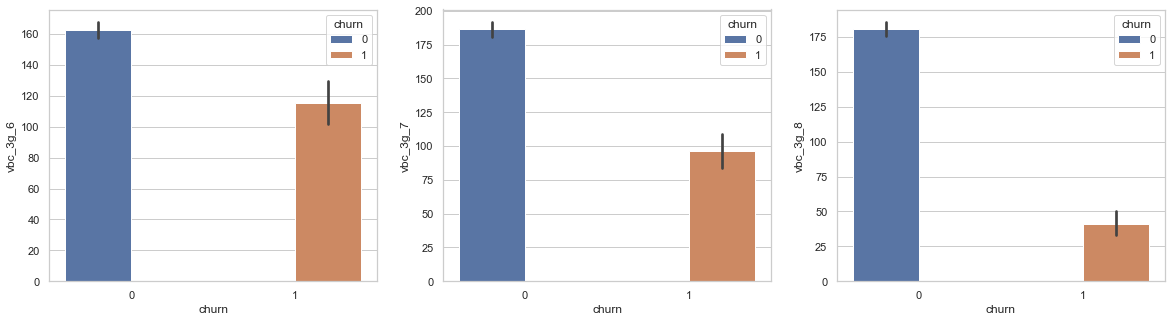

In [32]:
mnth = 6
plt.figure(figsize = (20,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    sns.barplot(x = churn_df.churn, y = churn_df['vbc_3g_'+str(mnth)], hue = churn_df.churn)
    mnth+=1

> <b>`INSIGHT`</b>
- The `value based cost` for churned customers is less when compared to non-churned customers
- There is a drop in 8th month (Active month)

> <b>`sachet_2g` & `sachet_3g`

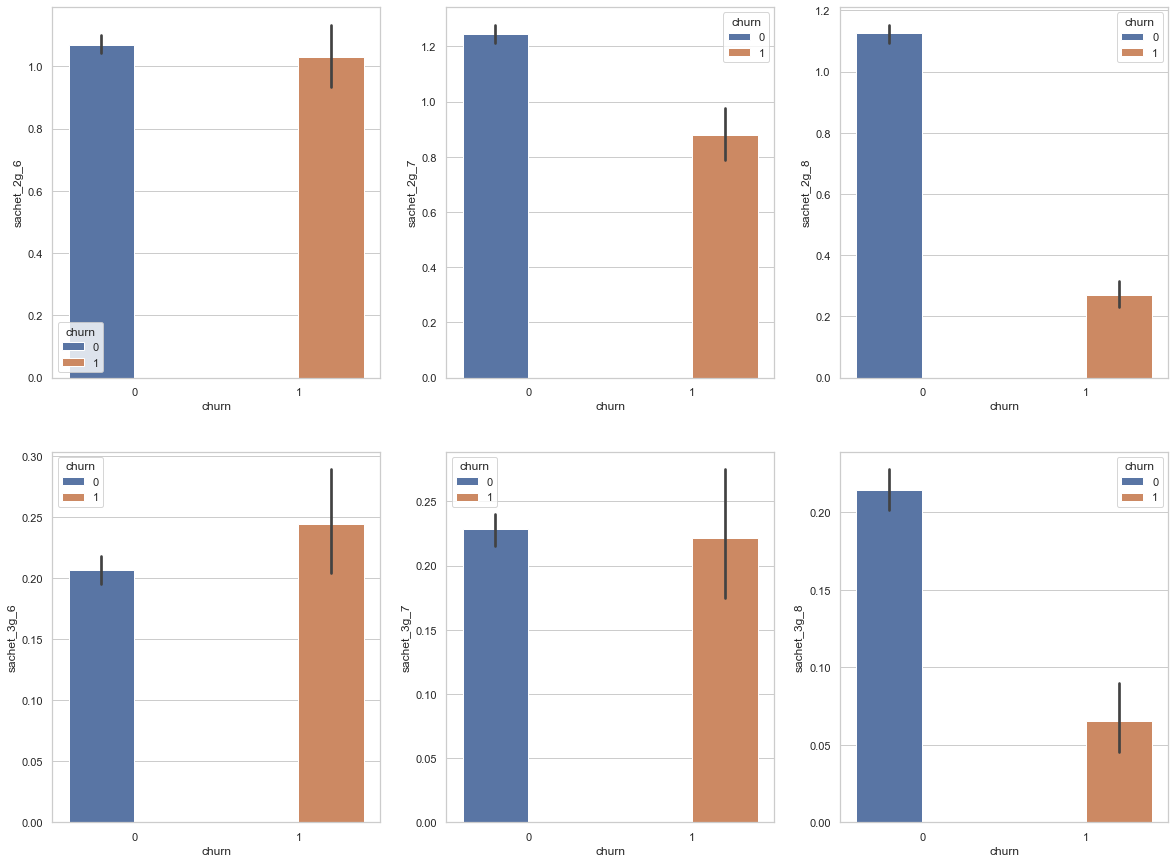

In [33]:
mnth = 6
plt.figure(figsize = (20,15))
for i in range(1,7):
    plt.subplot(2,3,i)
    if i<=3:
        sns.barplot(x = churn_df.churn, y = churn_df['sachet_2g_'+str(mnth)], hue = churn_df.churn)
        mnth+=1
    else:
        if mnth == 9:
            mnth = 6
        sns.barplot(x = churn_df.churn, y = churn_df['sachet_3g_'+str(mnth)], hue = churn_df.churn)
        mnth+=1    

> <b>`INSIGHT`</b>
- There is a drop in `sachets` for both `2G` and `3G` in the 8th month (Active month)

><b>`Average Revenue Per User (ARPU)`<b>

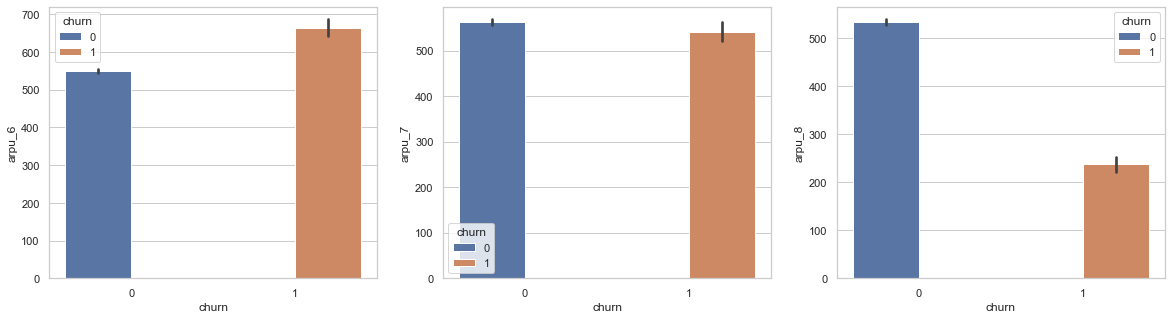

In [34]:
mnth = 6
plt.figure(figsize = (20,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    sns.barplot(x = churn_df.churn, y = churn_df['arpu_'+str(mnth)], hue = churn_df.churn)
    mnth+=1

> <b>`INSIGHT`</b>
- There is a drop in `arpu` in the 8th month.

> <b>`Minutes of Usage (mou)`</b>

In [35]:
mou_cols = churn_df.columns[churn_df.columns.str.contains('mou')]
100*(churn_df[mou_cols].isnull().sum()/churn_df.shape[0]).sort_values(ascending=False)

isd_ic_mou_8        3.913203
loc_og_t2m_mou_8    3.913203
spl_og_mou_8        3.913203
std_og_mou_8        3.913203
std_og_t2f_mou_8    3.913203
std_og_t2m_mou_8    3.913203
loc_ic_t2t_mou_8    3.913203
std_og_t2t_mou_8    3.913203
loc_ic_t2m_mou_8    3.913203
loc_og_mou_8        3.913203
loc_ic_t2f_mou_8    3.913203
loc_og_t2c_mou_8    3.913203
loc_ic_mou_8        3.913203
isd_og_mou_8        3.913203
std_ic_t2t_mou_8    3.913203
loc_og_t2f_mou_8    3.913203
std_ic_t2m_mou_8    3.913203
onnet_mou_8         3.913203
loc_og_t2t_mou_8    3.913203
spl_ic_mou_8        3.913203
std_ic_t2f_mou_8    3.913203
roam_og_mou_8       3.913203
std_ic_mou_8        3.913203
offnet_mou_8        3.913203
roam_ic_mou_8       3.913203
roam_ic_mou_6       1.816606
std_og_mou_6        1.816606
offnet_mou_6        1.816606
std_og_t2f_mou_6    1.816606
roam_og_mou_6       1.816606
std_og_t2m_mou_6    1.816606
loc_og_t2f_mou_6    1.816606
std_og_t2t_mou_6    1.816606
loc_og_mou_6        1.816606
loc_og_t2t_mou

> Maximum null values are 3.91%, which means these that customers are not using it much. So, we can fill the missing values with 0

In [36]:
churn_df[mou_cols] = churn_df[mou_cols].replace(np.nan, 0)
churn_df[mou_cols].isnull().sum().sort_values(ascending=False)

isd_ic_mou_8        0
isd_og_mou_6        0
loc_og_t2c_mou_6    0
loc_og_t2c_mou_7    0
loc_og_t2c_mou_8    0
loc_og_mou_6        0
loc_og_mou_7        0
loc_og_mou_8        0
std_og_t2t_mou_6    0
std_og_t2t_mou_7    0
std_og_t2t_mou_8    0
std_og_t2m_mou_6    0
std_og_t2m_mou_7    0
std_og_t2m_mou_8    0
std_og_t2f_mou_6    0
std_og_t2f_mou_7    0
std_og_t2f_mou_8    0
std_og_mou_6        0
std_og_mou_7        0
loc_og_t2f_mou_8    0
loc_og_t2f_mou_7    0
loc_og_t2f_mou_6    0
roam_ic_mou_8       0
onnet_mou_7         0
onnet_mou_8         0
offnet_mou_6        0
offnet_mou_7        0
offnet_mou_8        0
roam_ic_mou_6       0
roam_ic_mou_7       0
roam_og_mou_6       0
loc_og_t2m_mou_8    0
roam_og_mou_7       0
roam_og_mou_8       0
loc_og_t2t_mou_6    0
loc_og_t2t_mou_7    0
loc_og_t2t_mou_8    0
loc_og_t2m_mou_6    0
loc_og_t2m_mou_7    0
std_og_mou_8        0
isd_og_mou_7        0
isd_ic_mou_7        0
isd_og_mou_8        0
std_ic_t2t_mou_8    0
std_ic_t2m_mou_6    0
std_ic_t2m

> <b>`Outgoing minutes of usage` columns

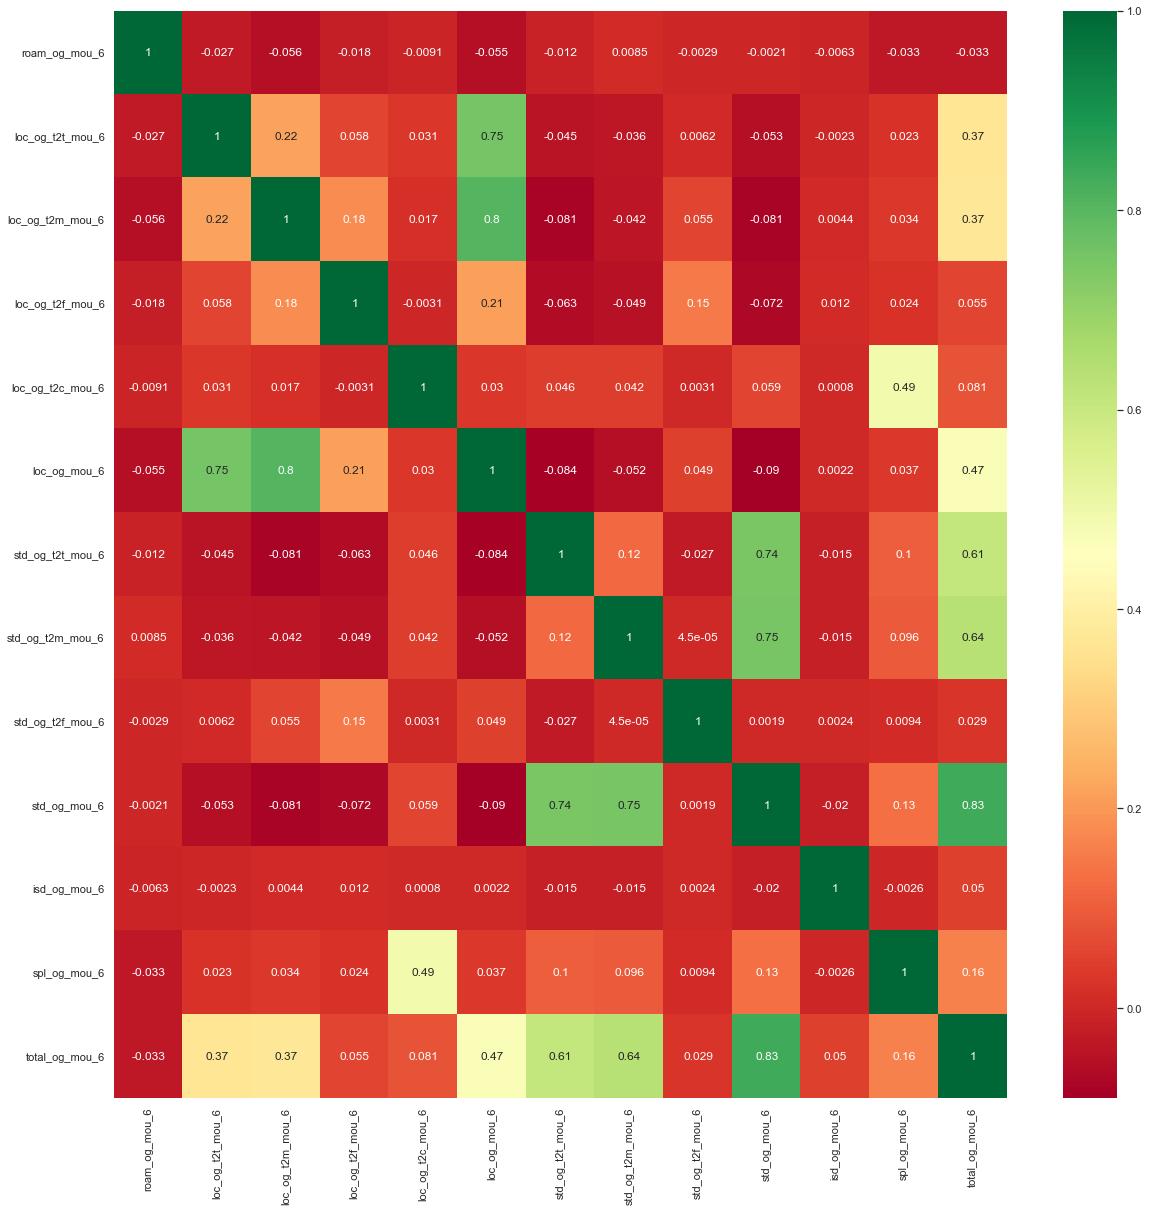

In [37]:
mou_og_cols6 = churn_df.columns[churn_df.columns.str.contains('.*_og_.*mou_6',regex=True)]
plt.figure(figsize=(20,20))
sns.heatmap(churn_df[mou_og_cols6].corr(), annot = True, cmap = 'RdYlGn')
plt.show()

> <b>`INSIGHT`</b>
- We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 is having high correlation. So, we can remove these columns for all months from the data set

In [38]:
list_total_og_cols = churn_df.columns[churn_df.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
churn_df.drop(list_total_og_cols,axis=1,inplace=True)
churn_df.shape

(30001, 142)

> **Checking for incoming mou variables**

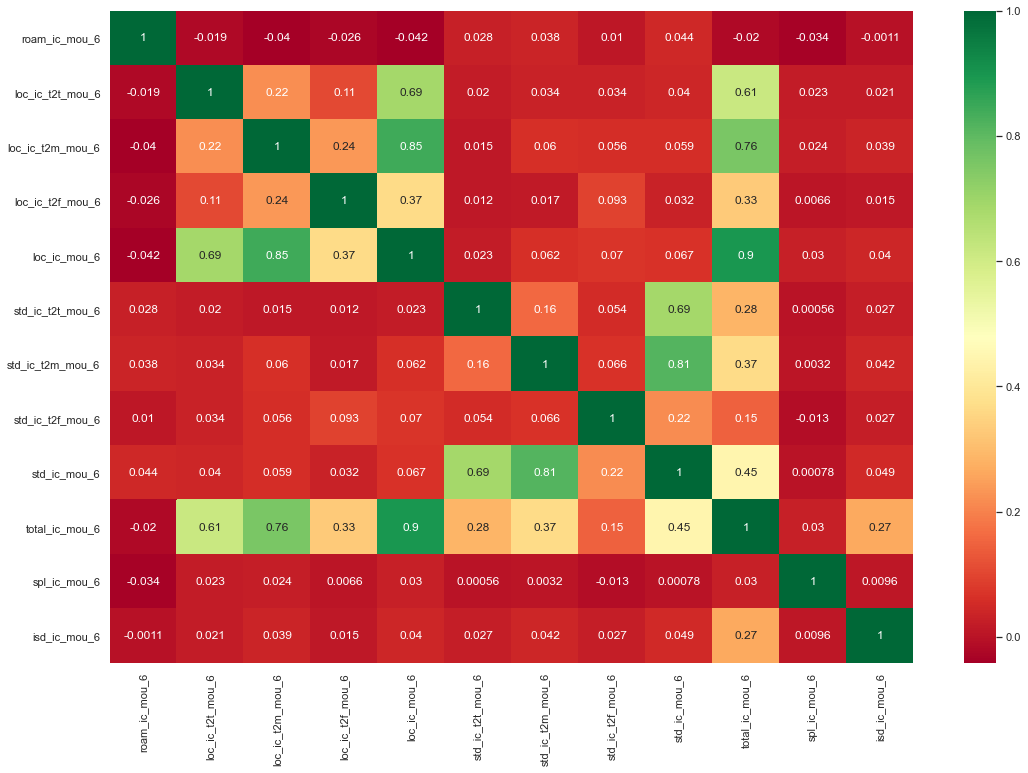

In [39]:
mou_ic_cols6 = churn_df.columns[churn_df.columns.str.contains('.*_ic_.*mou_6',regex=True)]
plt.figure(figsize=(18,12))
sns.heatmap(churn_df[mou_ic_cols6].corr(), annot = True, cmap = 'RdYlGn')
plt.show()

> <b>INSIGHT</b>
- We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fields. So, we can remove these columns for all months from the data set

In [40]:
list_total_ic_cols = churn_df.columns[churn_df.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
churn_df.drop(list_total_ic_cols,axis=1,inplace=True)
churn_df.shape

(30001, 133)

> <b>`OFFNET Usage`</b>

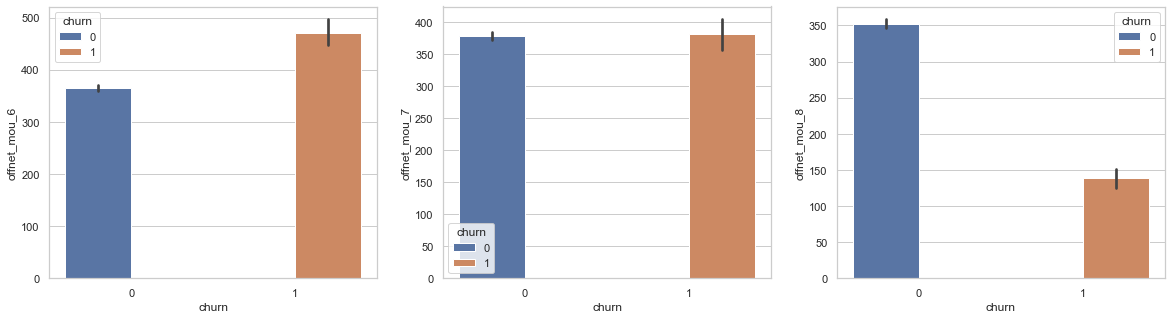

In [41]:
mnth = 6
plt.figure(figsize = (20,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    if i<=3:
        sns.barplot(x = churn_df.churn, y = churn_df['offnet_mou_'+str(mnth)], hue = churn_df.churn)
        mnth+=1

> <b>INSIGHT</b>
- There is a drop in `OFFNET usage` in 8th month(Active Period)

> <b>ONNET Usage</b>

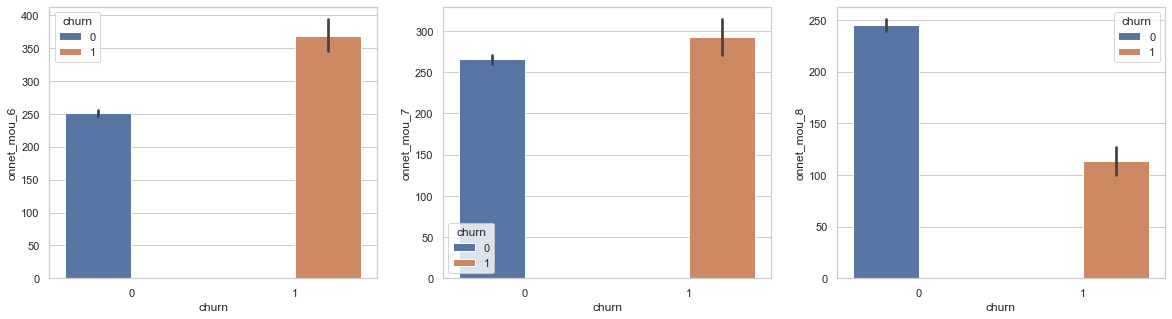

In [42]:
mnth = 6
plt.figure(figsize = (20,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    if i<=3:
        sns.barplot(x = churn_df.churn, y = churn_df['onnet_mou_'+str(mnth)], hue = churn_df.churn)
        mnth+=1

> <b>INSIGHT</b>
- We also see that there is a drop in `Onnet usage` in the 8th month for churned customers

> <b>Tenure Analysis</b>

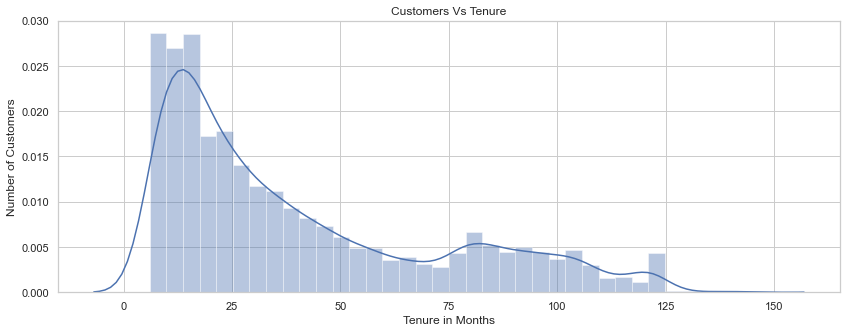

In [43]:
tenure_data = churn_df.copy()
plt.figure(figsize=(14,5))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
ax = sns.distplot(tenure_data['tenure'], hist=True,bins=36)
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

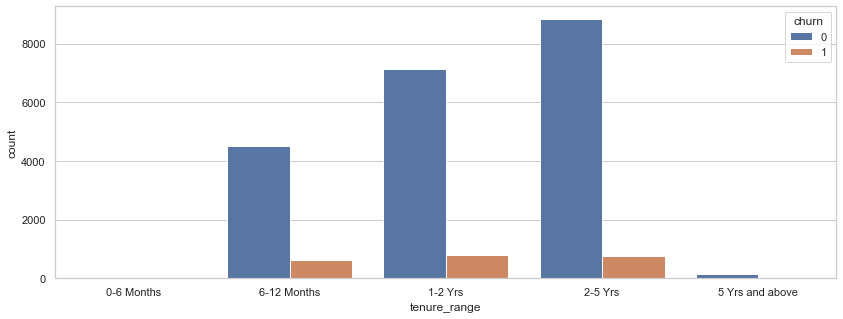

In [44]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)

plt.figure(figsize=(14,5))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data)
plt.show()

> ### Dropping columns with more than 30% Null values

In [45]:
null_30 = churn_df.columns[100*(churn_df.isnull().sum()/churn_df.shape[0])>30]
100*(churn_df[null_30].isnull().sum()/churn_df.shape[0]).sort_values(ascending=False)

fb_user_8                   46.825106
night_pck_user_8            46.825106
date_of_last_rech_data_8    46.825106
fb_user_6                   44.148528
night_pck_user_6            44.148528
date_of_last_rech_data_6    44.148528
fb_user_7                   43.145228
night_pck_user_7            43.145228
date_of_last_rech_data_7    43.145228
dtype: float64

In [46]:
churn_df.drop(null_30, axis = 1, inplace = True)
churn_df.shape

(30001, 124)

> ### Replacing NaN values

In [47]:
null_col = churn_df.columns[100*(churn_df.isnull().sum()/churn_df.shape[0])>0]
100*(churn_df[null_col].isnull().sum()/churn_df.shape[0]).sort_values(ascending=False)

ic_others_8            3.913203
og_others_8            3.913203
date_of_last_rech_8    1.943269
ic_others_6            1.816606
og_others_6            1.816606
ic_others_7            1.789940
og_others_7            1.789940
date_of_last_rech_7    0.326656
date_of_last_rech_6    0.243325
dtype: float64

In [48]:
churn_df[null_col].describe()

,og_others_6,og_others_7,og_others_8,ic_others_6,ic_others_7,ic_others_8
count,29456.000000,29464.000000,28827.000000,29456.000000,29464.000000,28827.000000
mean,0.673327,0.043687,0.059953,1.174797,1.527683,1.274327
std,4.145009,2.700992,3.381930,14.115478,16.142670,13.036589
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.060000,0.000000,0.060000
max,609.809998,370.130005,394.929993,1344.140015,1495.939941,1209.859985


> <b>Numerical columns</b>
- Replacing NaN values with zero for all numeric data as most of the data is clean and will not impact the analysis much

In [49]:
num_col = ['og_others_8', 'ic_others_8', 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']
churn_df[num_col] = churn_df[num_col].replace(np.nan, 0.0)
churn_df[num_col].isnull().sum().sort_values(ascending=False)

ic_others_7    0
og_others_7    0
ic_others_6    0
og_others_6    0
ic_others_8    0
og_others_8    0
dtype: int64

> - Dropping `Average_recharge_6_7`, and columns with `date_` because these doesn't bring much to the table

In [50]:
date_col = churn_df.filter(regex='date_').columns.to_list() + ['Average_recharge_6_7']

churn_df.drop(date_col, axis = 1, inplace = True)

In [51]:
churn_df.isnull().sum().sort_values(ascending=False)

churn                    0
total_data_recharge_8    0
std_og_t2m_mou_6         0
std_og_t2m_mou_7         0
std_og_t2m_mou_8         0
std_og_t2f_mou_6         0
std_og_t2f_mou_7         0
std_og_t2f_mou_8         0
isd_og_mou_6             0
isd_og_mou_7             0
isd_og_mou_8             0
spl_og_mou_6             0
spl_og_mou_7             0
spl_og_mou_8             0
og_others_6              0
og_others_7              0
og_others_8              0
loc_ic_t2t_mou_6         0
loc_ic_t2t_mou_7         0
loc_ic_t2t_mou_8         0
loc_ic_t2m_mou_6         0
loc_ic_t2m_mou_7         0
loc_ic_t2m_mou_8         0
loc_ic_t2f_mou_6         0
loc_ic_t2f_mou_7         0
loc_ic_t2f_mou_8         0
std_ic_t2t_mou_6         0
std_ic_t2t_mou_7         0
std_ic_t2t_mou_8         0
std_og_t2t_mou_8         0
std_og_t2t_mou_7         0
std_og_t2t_mou_6         0
roam_og_mou_6            0
arpu_6                   0
arpu_7                   0
arpu_8                   0
onnet_mou_6              0
o

> **Creating new features**

In [52]:
col_list = churn_df.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    churn_df[avg_col_name] = (churn_df[col_6]  + churn_df[col_7])/ 2

arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_data_recharge


> - Created new columns.Hence, dropping the old columns

In [53]:
col_list_to_drop = churn_df.filter(regex='_6|_7')
churn_df.drop(col_list_to_drop,axis=1,inplace=True)
churn_df.shape

(30001, 81)

> # Data Preprocessing
   - Creating X, y Datasets (X = all features except `churn`(target variable), `mobile_number` which is kind of index. y = `churn`

In [54]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split

Y = churn_df["churn"]
X = churn_df.drop(["churn","mobile_number"],axis=1)
X.shape, Y.shape

((30001, 79), (30001,))

> ## Train-Test Split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, train_size=0.7, random_state=1)

> ## Scaling the data using `StandardScaler`

In [56]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

> ## Using `SMOTE` to reduce imbalance in the dataset

In [57]:
from imblearn.over_sampling import SMOTE
#Initializing SMOTE: Synthetic Minority Over-sampling Technique
# using this as data is skewed 
smote = SMOTE()
X_train,y_train = smote.fit_sample(X_train,y_train)
print("Shape of train datatset after SMOTE : "+str(X_train.shape))

Shape of train datatset after SMOTE : (38576, 79)


> # MODEL BUILDING
> ## LOGISTIC REGRESSION
- Using RFE(Recursive Feature Elimination) to filter out features 

In [58]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE
rfe = RFE(logreg,15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_8', False, 23),
 ('onnet_mou_8', False, 63),
 ('offnet_mou_8', False, 25),
 ('roam_ic_mou_8', False, 62),
 ('roam_og_mou_8', False, 38),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_8', False, 58),
 ('loc_og_t2c_mou_8', False, 57),
 ('std_og_t2t_mou_8', False, 24),
 ('std_og_t2m_mou_8', False, 50),
 ('std_og_t2f_mou_8', False, 32),
 ('isd_og_mou_8', False, 53),
 ('spl_og_mou_8', False, 28),
 ('og_others_8', True, 1),
 ('loc_ic_t2t_mou_8', True, 1),
 ('loc_ic_t2m_mou_8', True, 1),
 ('loc_ic_t2f_mou_8', True, 1),
 ('std_ic_t2t_mou_8', False, 2),
 ('std_ic_t2m_mou_8', False, 14),
 ('std_ic_t2f_mou_8', True, 1),
 ('spl_ic_mou_8', False, 3),
 ('isd_ic_mou_8', False, 42),
 ('ic_others_8', False, 45),
 ('total_rech_num_8', True, 1),
 ('total_rech_amt_8', False, 10),
 ('max_rech_amt_8', False, 11),
 ('last_day_rch_amt_8', True, 1),
 ('total_rech_data_8', True, 1),
 ('max_rech_data_8', False, 4),
 ('av_rech_amt_data_8', False, 19),
 ('vol_2g_mb_8', F

In [59]:
import statsmodels.api as sm
column = X_train.columns[rfe.support_]
# Logistic regression model
logm = sm.GLM(y_train,(sm.add_constant(X_train[column])), family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38560
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 30 Nov 2020   Deviance:                          nan
Time:                        22:44:30   Pearson chi2:                 2.21e+06
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.3461      0.096    -24.319      0.000      -2.535      -2.157
loc_og_t2t_mou_8           -1.1700      0.085    -13.822      0.000      -1.336      -1.004
loc_og_t2m_mou_8           -0.6229      0.048    -13.047      0.000      -0.716      -0.529
og_others_8               -11.6946      4.981     -2.348      0.019     -21.458      -1.932
loc_ic_t2t_mou_8           -1.2081      0.085    -14.225      0.000      -1.375      -1.042
loc_ic_t2m_mou_8           -2.2634      0.079    -28.733      0.000      -2.418      -2.109
loc_ic_t2f_mou_8           -0.4845      0.056     -8.603      0.000      -0.595      -0.374
std_ic_t2f_mou_8           -0.5052      0.071     -7.076      0.000      -0.645      -0.365
total_rech_num_8           -0.6612      0.023    -28.271      0.000      -0.707      -0.615
last_day_rch_amt_8         -0.6452      0.023    -28.281      0.000      -0.690      -0.601
total_rech_data_8          -0.9501      0.033    -29.010      0.000      -1.014      -0.886
avg_arpu_av67               0.4501      0.021     21.888      0.000       0.410       0.490
avg_onnet_mou_av67          1.0445      0.078     13.348      0.000       0.891       1.198
avg_std_og_t2t_mou_av67    -0.9456      0.069    -13.633      0.000      -1.082      -0.810
avg_loc_ic_t2m_mou_av67     0.7874      0.043     18.446      0.000       0.704       0.871
avg_monthly_2g_av67        -0.4361      0.019    -22.973      0.000      -0.473      -0.399
===========================================================================================
"""

>**Check VIF values of feature variables.** 

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[column].columns
vif['VIF'] = [variance_inflation_factor(X_train[column].values, i) for i in range(X_train[column].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,avg_onnet_mou_av67,12.17
12,avg_std_og_t2t_mou_av67,11.17
4,loc_ic_t2m_mou_8,2.89
0,loc_og_t2t_mou_8,2.32
13,avg_loc_ic_t2m_mou_av67,2.13
1,loc_og_t2m_mou_8,1.82
7,total_rech_num_8,1.45
10,avg_arpu_av67,1.33
9,total_rech_data_8,1.29
3,loc_ic_t2t_mou_8,1.23


> **Training the model on the train data**

In [61]:
from sklearn import metrics

rfe_cols = X_train.columns[rfe.support_]
lr = LogisticRegression()
model = lr.fit(X_train[rfe_cols],y_train)

> **Making prediction on the test data**

In [62]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
pred_probs_test = model.predict_proba(X_test[rfe_cols])[:,1]

print("Logistic Regression Accuracy :",round(metrics.roc_auc_score(y_test, pred_probs_test),2))

Logistic Regression Accuracy : 0.87


> Determining **Feature Importance**

In [63]:
new_params = res.params[1:]
new_params.sort_values()
feature_importance = 100.0 * (new_params / new_params.max())
abs(new_params).sort_values(ascending=False)

og_others_8                11.694650
loc_ic_t2m_mou_8            2.263387
loc_ic_t2t_mou_8            1.208125
loc_og_t2t_mou_8            1.170048
avg_onnet_mou_av67          1.044472
total_rech_data_8           0.950065
avg_std_og_t2t_mou_av67     0.945613
avg_loc_ic_t2m_mou_av67     0.787421
total_rech_num_8            0.661227
last_day_rch_amt_8          0.645226
loc_og_t2m_mou_8            0.622863
std_ic_t2f_mou_8            0.505157
loc_ic_t2f_mou_8            0.484544
avg_arpu_av67               0.450139
avg_monthly_2g_av67         0.436109
dtype: float64

In [64]:
new_params

loc_og_t2t_mou_8           -1.170048
loc_og_t2m_mou_8           -0.622863
og_others_8               -11.694650
loc_ic_t2t_mou_8           -1.208125
loc_ic_t2m_mou_8           -2.263387
loc_ic_t2f_mou_8           -0.484544
std_ic_t2f_mou_8           -0.505157
total_rech_num_8           -0.661227
last_day_rch_amt_8         -0.645226
total_rech_data_8          -0.950065
avg_arpu_av67               0.450139
avg_onnet_mou_av67          1.044472
avg_std_og_t2t_mou_av67    -0.945613
avg_loc_ic_t2m_mou_av67     0.787421
avg_monthly_2g_av67        -0.436109
dtype: float64

In [65]:
sorted_idx = np.argsort(feature_importance,kind='quicksort',order='list of str')
sorted_idx.sort_values(ascending=True)

loc_ic_t2t_mou_8            0
last_day_rch_amt_8          1
loc_og_t2t_mou_8            2
og_others_8                 3
loc_og_t2m_mou_8            4
avg_arpu_av67               5
total_rech_data_8           6
std_ic_t2f_mou_8            7
total_rech_num_8            8
loc_ic_t2m_mou_8            9
avg_std_og_t2t_mou_av67    10
avg_monthly_2g_av67        11
loc_ic_t2f_mou_8           12
avg_loc_ic_t2m_mou_av67    13
avg_onnet_mou_av67         14
dtype: int64

> **Plot showing the feature variables based on their relative coefficient values**

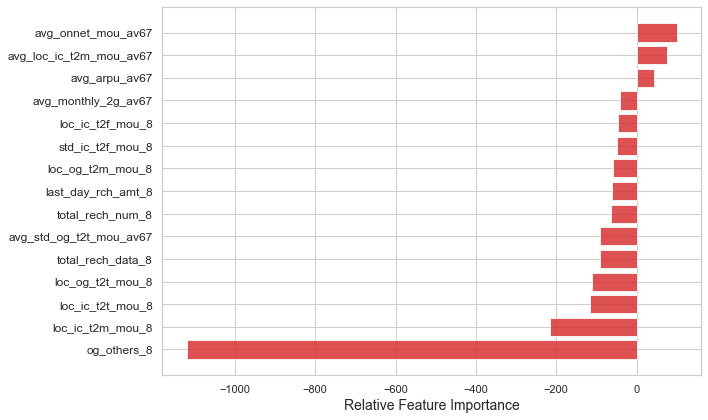

In [66]:
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,6))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color = 'tab:red',alpha=0.8)
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train[column].columns)[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance', fontsize=14)

plt.tight_layout()   
plt.show()

> ## SVM (Support Vector Machines)
> ### PCA (Principal Component Analysis)

In [67]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

# splitting the X and y
y = churn_df["churn"]
X = churn_df.drop(["churn","mobile_number"],axis=1)
X.shape, y.shape    

((30001, 79), (30001,))

> **Train-Test Split**

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21000, 79), (9001, 79), (21000,), (9001,))

> **Standard Scaler**

In [69]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

> **Scree Plot**

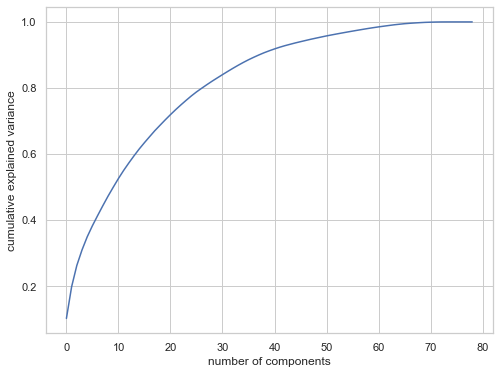

,PC1,PC2,PC3,Feature
0,-0.001031,0.296664,0.148460,arpu_8
1,-0.115427,0.121372,0.157454,onnet_mou_8
2,-0.104940,0.201241,0.115478,offnet_mou_8
3,-0.008124,0.052051,0.006683,roam_ic_mou_8
4,-0.022593,0.067709,0.033896,roam_og_mou_8
5,-0.031911,0.102859,0.032906,loc_og_t2t_mou_8
6,-0.032531,0.182877,-0.022812,loc_og_t2m_mou_8
7,0.008052,0.112572,-0.092050,loc_og_t2f_mou_8
8,-0.013081,0.014939,0.082946,loc_og_t2c_mou_8
9,-0.112475,0.074938,0.159429,std_og_t2t_mou_8


In [70]:
def get_scree_plot(X):
    pca = PCA(svd_solver='randomized', random_state=101)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return pca
pca = get_scree_plot(X_train) # scree plot

col = list(X_train.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

In [71]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.33,  19.91,  26.36,  31.06,  35.03,  38.39,  41.45,  44.43,
        47.31,  50.02,  52.65,  55.1 ,  57.37,  59.54,  61.6 ,  63.5 ,
        65.33,  67.13,  68.78,  70.41,  71.98,  73.49,  74.92,  76.29,
        77.62,  78.84,  79.95,  81.04,  82.09,  83.09,  84.08,  85.05,
        85.99,  86.9 ,  87.76,  88.57,  89.32,  90.03,  90.7 ,  91.3 ,
        91.86,  92.38,  92.85,  93.27,  93.68,  94.06,  94.43,  94.8 ,
        95.14,  95.48,  95.81,  96.11,  96.41,  96.7 ,  96.98,  97.26,
        97.53,  97.8 ,  98.06,  98.3 ,  98.53,  98.74,  98.95,  99.16,
        99.33,  99.49,  99.61,  99.71,  99.81,  99.89,  99.94,  99.98,
       100.01, 100.02, 100.02, 100.02, 100.02, 100.02, 100.02])

> <b>`INSIGHT`</b>
- Looks like 60 components are enough to describe 95% of the variance in the dataset.We'll choose 60 components for our modeling

> **SMOTE**

In [72]:
from imblearn.over_sampling import SMOTE
#Initializing SMOTE: Synthetic Minority Over-sampling Technique
# using this as data is skewed 
smote = SMOTE()
X_train,y_train = smote.fit_sample(X_train,y_train)
print("Shape of train datatset after SMOTE : "+str(X_train.shape))

Shape of train datatset after SMOTE : (38576, 79)


> ### Applying PCA : Principal Component Analysis

In [73]:
pca = IncrementalPCA(n_components=60)    
x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(X_test)
print("Shape of train datatset after PCA : "+str(x_train_pca.shape))

Shape of train datatset after PCA : (38576, 60)


> ## SVM Model Building (Linear)

In [74]:
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn import metrics
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.metrics import recall_score,precision_score,roc_auc_score,f1_score,accuracy_score,confusion_matrix

# SVM Model (linear kernal)
kernel = 'linear'
model = svm.SVC(kernel=kernel) # build model
model.fit(X_train, y_train) # fit model
y_pred = model.predict(X_test) # print
accuracy_score = round(metrics.accuracy_score(y_true=y_test, y_pred=y_pred),2)
print("Model selected - "+kernel.upper()+" and accuracy score for kernal is "+str(accuracy_score*100))
model_name = "SVM (Default)-"+kernel

Model selected - LINEAR and accuracy score for kernal is 89.0


SVM (Default)-linear Model Stats Scores Summary : 


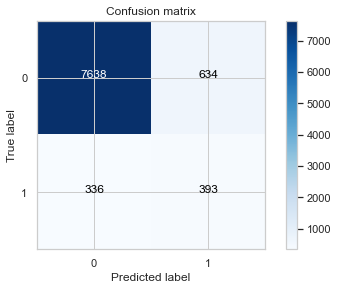

In [75]:
print(model_name+" Model Stats Scores Summary : ")
y_pred = pd.Series(y_pred)
cp = confusion_matrix(y_test,y_pred)
plt.figure()
classes=[0,1]
cmap=plt.cm.Blues
plt.imshow(cp, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes)
thresh = cp.max() / 2.
for i, j in itertools.product(range(cp.shape[0]), range(cp.shape[1])):
    plt.text(j, i, cp[i, j],horizontalalignment="center",color="white" if cp[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

> ## SVM Model Building (rbf)

In [76]:
# SVM Model (rbf kernal)
kernel = 'rbf'
model = svm.SVC(kernel=kernel) # build model
model.fit(X_train, y_train) # fit model
predictions = model.predict(X_test) # print
accuracy_score = round(metrics.accuracy_score(y_true=y_test, y_pred=predictions),2)
print("Model selected - "+kernel.upper()+" and accuracy score for kernal is "+str(accuracy_score*100))
model_name = "SVM (Default)-"+kernel

Model selected - RBF and accuracy score for kernal is 92.0


SVM (Default)-rbf Model Stats Scores Summary : 


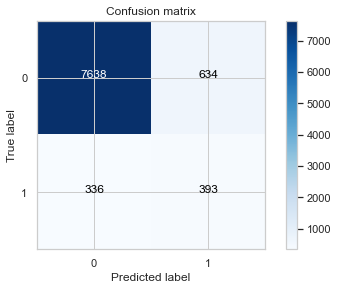

In [77]:
# Printing confusion matrix

print(model_name+" Model Stats Scores Summary : ")
cm = confusion_matrix(y_test,y_pred)
plt.figure()
classes=[0,1]
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

> ### GRIDSEARCHCV: Hyperparameter tuning
   - Let's now tune the model to find the optimal values of C and gamma corresponding to an RBF kernal. We will use 5-fold cross validation

In [78]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-1,1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]

# specify model
model = svm.SVC(kernel="rbf")

# set up GridSearchCV()
model_cv_svm = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv_svm.fit(X_train, y_train)  

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 75.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=1)

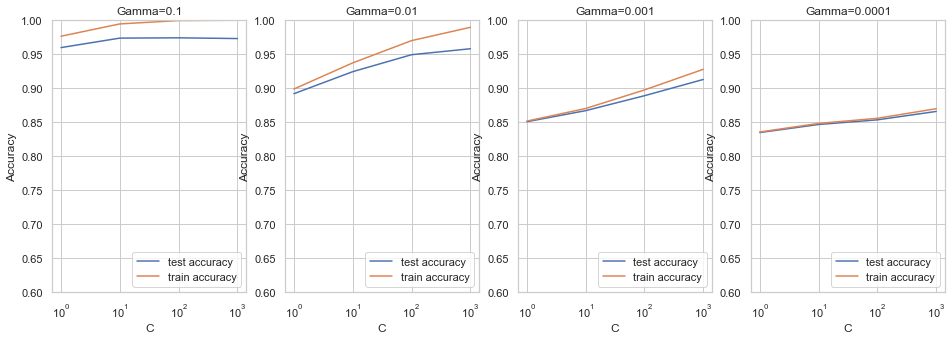

In [79]:
# cv results
svm_cv_results = pd.DataFrame(model_cv_svm.cv_results_)
svm_cv_results['param_C'] = svm_cv_results['param_C'].astype('int')
gamma=[1e-1,1e-2, 1e-3, 1e-4]
plt.figure(figsize=(16,5))
plt.subplot(141)
def display_hyper_stats(cv_results,param_value):
    gamma = cv_results[cv_results['param_gamma']==param_value]
    plt.plot(gamma["param_C"], gamma["mean_test_score"])
    plt.plot(gamma["param_C"], gamma["mean_train_score"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title("Gamma="+str(param_value))
    plt.ylim([0.60, 1])
    plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
    plt.xscale('log')  

display_hyper_stats(svm_cv_results,gamma[0])
plt.subplot(142)
display_hyper_stats(svm_cv_results,gamma[1])
plt.subplot(143)
display_hyper_stats(svm_cv_results,gamma[2])
plt.subplot(144)
display_hyper_stats(svm_cv_results,gamma[3])
plt.show()

> <span style='color:blue'>**Analysis:** The plots above show some useful insights:
>> - Non-linear models (high gamma) perform *much better* than the linear ones
>> - At any value of gamma, a high value of C leads to better performance
>> - Model with gamma = 0.1 tends to overfit and rest of the values seems to be good. 
>> - This suggests that the problem and the data is **inherently non-linear** in nature, and a complex model will outperform simple, linear models in this case.</span>

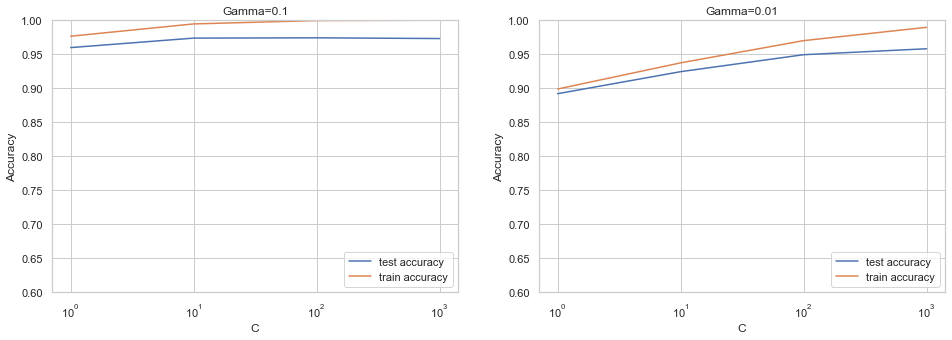

In [80]:
plt.figure(figsize=(16,5))
plt.subplot(121)
display_hyper_stats(svm_cv_results,gamma[0])
plt.subplot(122)
display_hyper_stats(svm_cv_results,gamma[1])

In [81]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv_svm.best_score_
best_hyperparams = model_cv_svm.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(round(best_score,2), best_hyperparams))

The best test score is 0.97 corresponding to hyperparameters {'C': 100, 'gamma': 0.1}


> <span style='color:blue'>**Analysis:** The plots above show some useful insights:<br>
> Looking at above curves and values , model with gamma=0.1 seems to be overfitting and should not be used.<br>
> Model selected with best value as 'C': 100, 'gamma': 0.1 but this model also seems to be overfitting<br>
> But model selected with value 'C': 10, 'gamma': 0.1 should produce better results.<br>
> We will be selecting these values for final modelling.<br>
</span>

> ### Building and Evaluating the Final Model
- Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [82]:
# model with optimal hyperparameters
final_svm_model = svm.SVC(C=10, gamma=0.1, kernel="rbf")

final_svm_model.fit(X_train, y_train)
y_pred = final_svm_model.predict(X_test)

# metrics
print("Max accuracy with SVM (rbf) is "+str(round(metrics.accuracy_score(y_test, y_pred),2)))

Max accuracy with SVM (rbf) is 0.92


SVM (Default)-rbf Model Stats Scores Summary : 


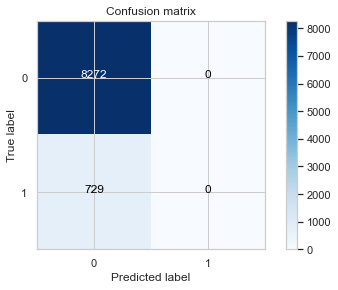

In [83]:
print(model_name+" Model Stats Scores Summary : ")
cm = confusion_matrix(y_test,y_pred)
plt.figure()
classes=[0,1]
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
    

# RANDOMFOREST

In [84]:
churn_randomforest= churn_df.copy()

In [85]:
y = churn_randomforest["churn"]
X = churn_randomforest.drop(["churn","mobile_number"],axis=1)
X.shape, y.shape   

((30001, 79), (30001,))

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, train_size=0.7, random_state=1)

In [87]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

In [88]:
smote = SMOTE()
X_train,y_train = smote.fit_sample(X_train,y_train)
print("Shape of train datatset after SMOTE : "+str(X_train.shape))

Shape of train datatset after SMOTE : (38576, 79)


In [89]:
pca = IncrementalPCA(n_components=60)    
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("Shape of train datatset after PCA : "+str(X_train_pca.shape))

Shape of train datatset after PCA : (38576, 60)


# Importing random forest classifier from sklearn library

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [91]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

# Making predictions
predictions = rfc.predict(X_test)

#print_model_metrics(y_test,predictions,"RandomForest (Default)")

SVM (Default)-rbf Model Stats Scores Summary : 


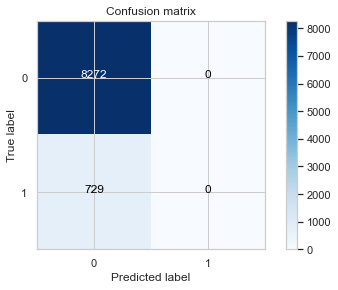

,Model,Accuracy,Precision,Recall,AUC,F1
0,SVM (Default)-rbf,0.92,0.0,0.0,0.5,0.0


In [92]:
print(model_name+" Model Stats Scores Summary : ")
cm = confusion_matrix(y_test,y_pred)
plt.figure()
classes=[0,1]
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
    
plt.show()
    
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)
    
data = [[model_name,accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
df

> ## HYPERPARAMETER TUNING

In [93]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

> #### Tuning max_depth
Let's try to find the optimum values for ```max_depth``` and understand how the value of max_depth impacts the overall accuracy of the ensemble.

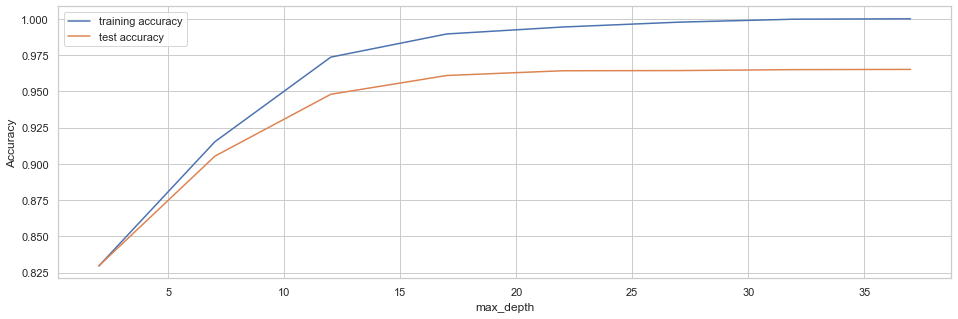

In [94]:
# parameters to build the model on
parameters = {'max_depth': range(2, 40, 5)}
n_folds = 5
max_depth=0

if(max_depth==0):
    rf = RandomForestClassifier()
else :
    rf = RandomForestClassifier(max_depth=max_depth)
        
rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)
scores = rf.cv_results_

for key in parameters.keys():
    hyperparameters = key
    break

# plotting accuracies for parameters
plt.figure(figsize=(16,5))
plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
plt.xlabel(hyperparameters)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

> <span style='color:blue'>**Analysis:** We can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score becomme stagnant. The ensemble tries to overfit as we increase the max_depth. Thus, controlling the depth of the constituent trees will help reduce overfitting in the forest. **12 and 18** value have peek convergens and can be used for grid veiw search.

> #### Tuning n_estimators
- Let's try to find the optimum values for n_estimators and understand how the value of n_estimators impacts the overall accuracy. Notice that we'll specify an appropriately low value of max_depth, so that the trees do not overfit.
<br>

In [ ]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 2000, 300)}
n_folds = 5
max_depth=0

if(max_depth==0):
    rf = RandomForestClassifier()
else :
    rf = RandomForestClassifier(max_depth=max_depth)
        
rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)
scores = rf.cv_results_

for key in parameters.keys():
    hyperparameters = key
    break

# plotting accuracies for parameters
plt.figure(figsize=(16,5))
plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
plt.xlabel(hyperparameters)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

> <span style='color:blue'>**Analysis:** :  Score almost remain the same with very low dip throught the range. We wull use **200** for grid view search.

> #### Tuning max_features
- Let's see how the model performance varies with ```max_features```, which is the maximum numbre of features considered for splitting at a node.

In [ ]:
# parameters to build the model on
parameters = {'max_features': [20,30,40,50,60]}
n_folds = 5
max_depth=0

if(max_depth==0):
    rf = RandomForestClassifier()
else :
    rf = RandomForestClassifier(max_depth=max_depth)
        
rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)
scores = rf.cv_results_

for key in parameters.keys():
    hyperparameters = key
    break

# plotting accuracies for parameters
plt.figure(figsize=(16,5))
plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
plt.xlabel(hyperparameters)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

> <span style='color:blue'>**Analysis:** Apparently, accuracy of training seems to be stable and test scores seems to increase till **30** and then decrease. Again we see increase on **40** and we will use that.

In [ ]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(1, 80, 10)}
n_folds = 5
max_depth=0

if(max_depth==0):
    rf = RandomForestClassifier()
else :
    rf = RandomForestClassifier(max_depth=max_depth)
        
rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)
scores = rf.cv_results_

for key in parameters.keys():
    hyperparameters = key
    break

# plotting accuracies for parameters
plt.figure(figsize=(16,5))
plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
plt.xlabel(hyperparameters)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

> <span style='color:blue'>**Analysis:** We can see that the model starts to overfit as value is decrease the value of min_samples_leaf. **10 to 20** seems to be a good range and that will be used in grid search.

In [ ]:
# parameters to build the model on
parameters = {'min_samples_split': range(10, 80, 10)}
n_folds = 5
max_depth=0

if(max_depth==0):
    rf = RandomForestClassifier()
else :
    rf = RandomForestClassifier(max_depth=max_depth)
        
rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
rf.fit(X_train, y_train)
scores = rf.cv_results_

for key in parameters.keys():
    hyperparameters = key
    break

# plotting accuracies for parameters
plt.figure(figsize=(16,5))
plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
plt.xlabel(hyperparameters)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

> <span style='color:blue'>**Analysis:** Range **10 to 30** is optimal with good accuracy. 

> #### Grid Search to Find Optimal Hyperparameters
- We can now find the optimal hyperparameters using GridSearchCV.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [12,18],
    'n_estimators': [200],
    'max_features': [40],
    'min_samples_leaf': [10,20],
    'min_samples_split': [10,20,30]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,return_train_score=True)

In [ ]:
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of '+str(round(rf_grid_search.best_score_,2))+' using '+str(rf_grid_search.best_params_))

In [ ]:
print("Max accuracy with Random Forest classifier - "+str(round(rf_grid_search.best_score_,2)))

> ### Building and Evaluating the Final Model for Random Forest
- Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [ ]:
rfc = RandomForestClassifier(max_depth=18,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=20,
                             n_estimators=200,
                             n_jobs = -1)
rfc.fit(X_train,y_train)

In [ ]:
# Making predictions
predictions = rfc.predict(X_test)

In [ ]:
# Printing confusion matrix

print(model_name+" Model Stats Scores Summary : ")
cm = confusion_matrix(y_test,y_pred)
plt.figure()
classes=[0,1]
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
    
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)
   
data = [[model_name,accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
df

# Recommendations

> ### Business Insights 

> <span style='color:blue'> Less number of **high value customer** are churing but for last **6 month** no new high valued cusotmer is onboarded which is concerning and company should concentrate on that aspect. </span>

> <span style='color:blue'> Customers with less than **4 years** of tenure are more likely to churn and company should concentrate more on that segment by rolling out new schems to that group. 

> <span style='color:blue'> **Average revenue per user** seems to be most important feature in determining churn prediction. 

> <span style='color:blue'> **Incoming** and **Outgoing Calls** on **romaing** for 8th month are strong indicators of churn behaviour

> <span style='color:blue'> **Local Outgoing calls** made to landline , fixedline , mobile and call center provides a strong indicator of churn behaviour.  

> <span style='color:blue'> Better 2G/3G area coverage where 2G/3G services are not good, it's strong indicator of churn behaviour.

> ### Model Insights 

> <span style='color:blue'> **SVM** with tuned hyperparameters produce best result on this dataset with 0.92 accuracy.

> <span style='color:blue'> **Random forest** also produce good accuracy with 0.91 (default overfit model) and 0.90 with tuned hyperparameters.

> <span style='color:blue'> **As per our analysis SVM and Random forest produce best accuracy and models can be selected to predict churn data for future dataset or production.**